# DogCatsRedux Kaggle Competition

### 1. Import required modules

In [1]:
# Rather than importing everything manually, we'll make things easy
# and load them all in utils.py, and just import them from there.

# 1. install bcolz (pip install bcolz)
# 2. install theano (pip install theano)
# 3. install keras (pip install keras)
# 4. install tensorflow (pip install tensorflow), (pip install tensorflow-gpu)
# 5. install protoclbuff (pip install protobuf)
%matplotlib inline 
import utils; reload(utils)
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


### 2. Load the data

In [2]:
base_path = '/home/ubuntu/data/redux/' #workspace directory
#gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
gen=image.ImageDataGenerator()

In [3]:
batch_size=100

In [4]:
batches = get_batches(base_path+'train', gen,shuffle=True, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(base_path+'valid', shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [6]:
val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

#### Check the shape of the labels 

In [7]:
trn_labels.shape

(23000, 2)

In [8]:
val_labels.shape

(2000, 2)

### 3. Load the VGG model

In [8]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

### 4. Kaggle Submission helper function

In [7]:
def test(model, test_path, batch_size=64):
    test_batches = get_batches(test_path, shuffle=False, batch_size=batch_size, class_mode=None)
    return test_batches, model.predict_generator(test_batches, test_batches.nb_sample)

In [8]:
from IPython.display import FileLink
def generateKaggleSubmitLink(model, test_path, output_path, batch_size=64):
    batches, preds = test(model, test_path, batch_size)
    filenames = batches.filenames
    isdog = preds[:,1]
    ids = [int(f[8:f.find('.')]) for f in filenames]
    subm = np.stack([ids, isdog], axis=1)
    np.savetxt(output_path, subm, fmt='%d,%.5f', header='id,label', comments='')
    return FileLink(output_path)

In [9]:
from IPython.display import FileLink
def generateKaggleSubmitLinkWithClip(model, test_path, output_path, batch_size=64):
    batches, preds = test(model, test_path, batch_size)
    filenames = batches.filenames
    isdog = np.clip(preds[:,1], 0.05, 0.95)
    ids = [int(f[8:f.find('.')]) for f in filenames]
    subm = np.stack([ids, isdog], axis=1)
    np.savetxt(output_path, subm, fmt='%d,%.5f', header='id,label', comments='')
    return FileLink(output_path)

### VGG architecture

In [10]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

Define the optimization algorithm

In [9]:
#opt = RMSprop(lr=0.1, rho=0.7) #what is rho?
opt = Adam()

Pop the last dense layer of 1000 outputs and add a new Dense node of 2 outputs

In [67]:
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(2, activation='softmax'))
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4,
                    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/4
23000/23000 [==============================] - 603s - loss: 0.1285 - acc: 0.9660 - val_loss: 0.0370 - val_acc: 0.9890
Epoch 2/4
23000/23000 [==============================] - 610s - loss: 0.0881 - acc: 0.9773 - val_loss: 0.0377 - val_acc: 0.9880
Epoch 3/4
23000/23000 [==============================] - 609s - loss: 0.0799 - acc: 0.9792 - val_loss: 0.0475 - val_acc: 0.9865
Epoch 4/4
23000/23000 [==============================] - 609s - loss: 0.0827 - acc: 0.9785 - val_loss: 0.0386 - val_acc: 0.9865


vgg model's val accuracy is .9865 after finetuning

Save this model

In [35]:
model.save_weights(base_path+"models/ft1.h5")

Submit to kaggle

In [73]:
#recreate the architecture
vgg = Vgg16()
model = vgg.model
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(2, activation='softmax'))
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights(base_path+"models/ft1.h5")

In [71]:
generateKaggleSubmitLink(model, base_path+'test', base_path+'subm_finetune_last.csv', batch_size*2)

Found 12500 images belonging to 1 classes.


/home/ubuntu/data/redux/subm_finetune_last.csv

Received score of 0.18761

## Retrain all the Dense layers
While retraining all the dense layers, it is important to load ft1.h5 which is the weights after finetuning the original vgg model.(Replacing last layer with Dense(2)). This is because we don't need to randomly initialize all the weights in the previous layers while training for weights in the last layer. 

In [44]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model
model.load_weights(base_path+"models/ft1.h5")
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(2, activation='softmax'))
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
layers = model.layers
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

conv_layers = layers[:last_conv_idx+1]
for layer in layers: layer.trainable = True
for layer in conv_layers: layer.trainable = False

In [84]:
#gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
gen = image.ImageDataGenerator()
batches = get_batches(base_path+'train', gen,shuffle=True, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(base_path+'valid', shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [49]:
for layer in model.layers:
    print layer.name,layer.trainable

lambda_8 False
zeropadding2d_92 False
convolution2d_92 False
zeropadding2d_93 False
convolution2d_93 False
maxpooling2d_37 False
zeropadding2d_94 False
convolution2d_94 False
zeropadding2d_95 False
convolution2d_95 False
maxpooling2d_38 False
zeropadding2d_96 False
convolution2d_96 False
zeropadding2d_97 False
convolution2d_97 False
zeropadding2d_98 False
convolution2d_98 False
maxpooling2d_39 False
zeropadding2d_99 False
convolution2d_99 False
zeropadding2d_100 False
convolution2d_100 False
zeropadding2d_101 False
convolution2d_101 False
maxpooling2d_40 False
zeropadding2d_102 False
convolution2d_102 False
zeropadding2d_103 False
convolution2d_103 False
zeropadding2d_104 False
convolution2d_104 False
maxpooling2d_42 True
flatten_13 True
dense_45 True
dropout_25 True
dense_46 True
dropout_26 True
dense_47 True


In [54]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=2, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/2
23000/23000 [==============================] - 599s - loss: 0.1883 - acc: 0.9751 - val_loss: 0.0926 - val_acc: 0.9865
Epoch 2/2
23000/23000 [==============================] - 601s - loss: 0.1738 - acc: 0.9780 - val_loss: 0.0910 - val_acc: 0.9865


In [55]:
model.save_weights(base_path+"models/ft2.h5")

In [56]:
base_path+"models/ft2.h5"

'/home/ubuntu/data/redux/models/ft2.h5'

#### Submit to kaggle

In [76]:
#recreate the architecture
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model
model.load_weights(base_path+"models/ft1.h5")
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(2, activation='softmax'))
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
layers = model.layers
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

conv_layers = layers[:last_conv_idx+1]
for layer in layers: layer.trainable = True
for layer in conv_layers: layer.trainable = False

#load weights
model.load_weights(base_path+"models/ft2.h5")

predict

In [62]:
generateKaggleSubmitLink(model, base_path+'test', base_path+'subm_finetune_all.csv', batch_size*2)

Found 12500 images belonging to 1 classes.


/home/ubuntu/data/redux/subm_finetune_all.csv

Received score of 0.31664 which not an improvement. Hence reduce learning rate, separate conv layer features and train more number of epochs

In [114]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model
#loading from ft1.h5 since ft2.h5 was not good
model.load_weights(base_path+"models/ft1.h5")
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(2, activation='softmax'))
layers = model.layers
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
# Dense layers - also known as fully connected or 'FC' layers
fc_layers = layers[last_conv_idx+1:]

extract the conv outpu and save so that if this becomes input other models, training will be MUCH faster

In [10]:
batches = get_batches(base_path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(base_path+'valid', shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

Save the result (above step is expensive)

In [ ]:
save_array(base_path + 'models/train_convlayer_features.bc', trn_features)
save_array(base_path + 'models/valid_convlayer_features.bc', val_features)

In [11]:
trn_features = load_array(base_path + 'models/train_convlayer_features.bc')
val_features = load_array(base_path + 'models/valid_convlayer_features.bc')

In [93]:
def tranf_wgts(layer): return [o for o in layer.get_weights()]

In [117]:
model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
    ])

for l1,l2 in zip(model.layers, fc_layers): l1.set_weights(tranf_wgts(l2))
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
#load weights
model.fit(trn_features, trn_labels, nb_epoch=8, 
             batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 37s - loss: 0.1120 - acc: 0.9663 - val_loss: 0.0350 - val_acc: 0.9855
Epoch 2/8
23000/23000 [==============================] - 36s - loss: 0.0280 - acc: 0.9907 - val_loss: 0.0376 - val_acc: 0.9875
Epoch 3/8
23000/23000 [==============================] - 37s - loss: 0.0124 - acc: 0.9960 - val_loss: 0.0362 - val_acc: 0.9880
Epoch 4/8
23000/23000 [==============================] - 37s - loss: 0.0068 - acc: 0.9977 - val_loss: 0.0415 - val_acc: 0.9885
Epoch 5/8
23000/23000 [==============================] - 37s - loss: 0.0042 - acc: 0.9984 - val_loss: 0.0351 - val_acc: 0.9890
Epoch 6/8
23000/23000 [==============================] - 37s - loss: 0.0031 - acc: 0.9989 - val_loss: 0.0426 - val_acc: 0.9875
Epoch 7/8
23000/23000 [==============================] - 37s - loss: 0.0027 - acc: 0.9989 - val_loss: 0.0584 - val_acc: 0.9870
Epoch 8/8
23000/23000 [==============================] - 37s -

In [119]:
model.save_weights(base_path+'models/ft2_2.h5')

This model might have overfit after epoch 4, but still submit the solution to see the score. We could add more technique on top of an overfit model to reduce it(augmentation, batchnormalization etc)

We need to first run the conv_model on the test data before we can use the model to do the prediction, 
since this models expects an inputshape = outputshape of conv model

In [12]:
test_batches = get_batches(base_path+'test', shuffle=False, batch_size=batch_size)

Found 12500 images belonging to 1 classes.


In [ ]:
tst_features = conv_model.predict_generator(test_batches, test_batches.nb_sample)

In [99]:
save_array(base_path + 'models/test_convlayer_features.bc', tst_features)

In [13]:
tst_features = load_array(base_path + 'models/test_convlayer_features.bc')

In [14]:
from IPython.display import FileLink
def generateKaggleSubmitLink2(model, batches, test_features, output_path, batch_size=64):
    preds = model.predict(test_features)
    filenames = batches.filenames
    isdog = preds[:,1]
    ids = [int(f[8:f.find('.')]) for f in filenames]
    subm = np.stack([ids, isdog], axis=1)
    np.savetxt(output_path, subm, fmt='%d,%.5f', header='id,label', comments='')
    return FileLink(output_path)

In [15]:
from IPython.display import FileLink
def generateKaggleSubmitLink2WithClip(model, batches, test_features, output_path, batch_size=64):
    preds = model.predict(test_features)
    filenames = batches.filenames
    isdog = np.clip(preds[:,1], 0.05, 0.95)
    ids = [int(f[8:f.find('.')]) for f in filenames]
    subm = np.stack([ids, isdog], axis=1)
    np.savetxt(output_path, subm, fmt='%d,%.5f', header='id,label', comments='')
    return FileLink(output_path)

In [109]:
generateKaggleSubmitLink2(model, test_batches, tst_features, base_path+'subm_finetune_all2.csv', batch_size*2)

/home/ubuntu/data/redux/subm_finetune_all2.csv

Received score of 0.19908 which is better than previous score. But there might be overfitting, but which can be mitigated later. To verify if there is overfitting, retrain with less number of epochs and submit again

In [111]:
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model
#load again from ft1.h5
model.load_weights(base_path+"models/ft1.h5")
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(2, activation='softmax'))
layers = model.layers
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)
# Dense layers - also known as fully connected or 'FC' layers
fc_layers = layers[last_conv_idx+1:]

model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
    ])

for l1,l2 in zip(model.layers, fc_layers): l1.set_weights(tranf_wgts(l2))
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
#load weights
model.fit(trn_features, trn_labels, nb_epoch=3, 
             batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 37s - loss: 0.1117 - acc: 0.9657 - val_loss: 0.0361 - val_acc: 0.9845
Epoch 2/3
23000/23000 [==============================] - 36s - loss: 0.0268 - acc: 0.9908 - val_loss: 0.0366 - val_acc: 0.9875
Epoch 3/3
23000/23000 [==============================] - 37s - loss: 0.0118 - acc: 0.9957 - val_loss: 0.0391 - val_acc: 0.9870


In [112]:
model.save_weights(base_path+'models/ft3.h5')

In [113]:
generateKaggleSubmitLink2(model, test_batches, tst_features, base_path+'subm_finetune_all3.csv', batch_size*2)

/home/ubuntu/data/redux/subm_finetune_all3.csv

Received score of 0.16935, which is better than previous score of 0.19 so the assumption of overfitting was right.

## Remove dropout
Dropout is added to remove overfitting, we could try to make the dropout 0 and see if the model performance increases. Will build two models one from ft3.h5(which was trained less number of times => originally less overfitting) and from ft2_2.h5(which was trained with more #epochs => originally more overfit) and compare the difference.

In [25]:
#A function to make weights half, this is done since the VGG model had dropout of 50% and since we are going to remove it to avoid underfitting
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

### ******reduce the learning rate

In [19]:
opt=Adam(lr=0.00001)

### Load the previous weights

In [11]:
#rebuild the architecture which was used for ft3.h5 and load the weights
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

model.pop()
model.add(Dense(2, activation='softmax'))
#load again from ft1.h5
model.load_weights(base_path+"models/ft1.h5")

for layer in model.layers: layer.trainable=False

In [13]:
layers = model.layers
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

conv_layers = layers[:last_conv_idx+1]

fc_model_tmp = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
    ])
fc_model_tmp.load_weights(base_path+'models/ft3.h5')

Output of Conv layer becomes the features(input for the FC model)

In [37]:
batches = get_batches(base_path+'train', shuffle=False, batch_size=batch_size)
val_batches = get_batches(base_path+'valid', shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)
trn_features = load_array(base_path + 'models/train_convlayer_features.bc')
val_features = load_array(base_path + 'models/valid_convlayer_features.bc')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Create the FC model

In [15]:
fc_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(2, activation='softmax')
    ])

In [20]:
for l1,l2 in zip(fc_model.layers, fc_model_tmp.layers) : l1.set_weights(proc_wgts(l2))
fc_model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
fc_model.fit(trn_features, trn_labels, nb_epoch=2, 
             batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/2
23000/23000 [==============================] - 31s - loss: 0.0187 - acc: 0.9941 - val_loss: 0.0288 - val_acc: 0.9890
Epoch 2/2
23000/23000 [==============================] - 31s - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0319 - val_acc: 0.9860


In [22]:
#Save the resulting weights
fc_model.save_weights(base_path+"models/no_dropout_ft3.h5")

In [ ]:
fc_model.load_weights(base_path+"models/no_dropout_ft3.h5")

Submit the model to kaggle

In [29]:
generateKaggleSubmitLink2(fc_model, test_batches, tst_features, base_path+'subm_no_dropout_ft3.csv', batch_size*2)

/home/ubuntu/data/redux/subm_no_dropout_ft3.csv

Received score of  0.16610. slight improvement over 0.16935

from ft2_2.h5 (originally overfit model)

In [20]:
#rebuild the architecture which was used for ft3.h5 and load the weights
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

model.pop()
model.add(Dense(2, activation='softmax'))
#load again from ft1.h5
model.load_weights(base_path+"models/ft1.h5")

for layer in model.layers: layer.trainable=False

In [21]:
layers = model.layers
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

conv_layers = layers[:last_conv_idx+1]

fc_model_tmp = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
    ])
fc_model_tmp.load_weights(base_path+'models/ft2_2.h5')

In [23]:
fc_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(2, activation='softmax')
    ])

In [26]:
for l1,l2 in zip(fc_model.layers, fc_model_tmp.layers) : l1.set_weights(proc_wgts(l2))
fc_model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
fc_model.fit(trn_features, trn_labels, nb_epoch=2, 
             batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/2
23000/23000 [==============================] - 31s - loss: 0.0076 - acc: 0.9978 - val_loss: 0.0378 - val_acc: 0.9880
Epoch 2/2
23000/23000 [==============================] - 30s - loss: 0.0010 - acc: 0.9999 - val_loss: 0.0427 - val_acc: 0.9895


In [35]:
fc_model.save_weights(base_path+"models/no_dropout_ft2_2.h5")

Submit the model to kaggle

In [27]:
fc_model.load_weights(base_path+"models/no_dropout_ft2_2.h5")

In [37]:
generateKaggleSubmitLink2(fc_model, test_batches, tst_features, base_path+'subm_no_dropout_ft2_2.csv', batch_size*2)

/home/ubuntu/data/redux/subm_no_dropout_ft2_2.csv

Received score of 0.18027 which is better than 0.19908 but not as good as removing dropout from ft3.h5

In [35]:
generateKaggleSubmitLink2WithClip(fc_model, test_batches, tst_features, base_path+'subm_no_dropout_ft2_2_clip.csv', batch_size*2)

/home/ubuntu/data/redux/subm_no_dropout_ft2_2_clip.csv

## Data Augmentation
Start from no_dropout_ft3.h5

In [16]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [17]:
batches = get_batches(base_path+'train', gen, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(base_path+'valid', shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


We need not train all the conv layers but we need to pass the input through the conv layers(instead of splittig conv and fc layers) since when data augmentation is applied, randomized changes are applied to each image.

In [12]:
#rebuild the architecture which was used for ft1.h5 and load the weights
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

model.pop()
model.add(Dense(2, activation='softmax'))
#load again from ft1.h5
model.load_weights(base_path+"models/ft1.h5")

In [13]:
#rebuild the architecture which was used for no_dropout_ft3.h5 and load the weights
layers = model.layers
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

conv_layers = layers[:last_conv_idx+1]
conv_model=Sequential(conv_layers)

fc_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(2, activation='softmax')
    ])
fc_model.load_weights(base_path+'models/no_dropout_ft3.h5')

Combine conv_model with fc_model

In [14]:
conv_model.add(fc_model)
for layer in conv_model.layers: layer.trainable = False
conv_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/8
23000/23000 [==============================] - 604s - loss: 0.0259 - acc: 0.9905 - val_loss: 0.0319 - val_acc: 0.9860
Epoch 2/8
23000/23000 [==============================] - 602s - loss: 0.0263 - acc: 0.9903 - val_loss: 0.0319 - val_acc: 0.9860
Epoch 3/8
23000/23000 [==============================] - 602s - loss: 0.0277 - acc: 0.9904 - val_loss: 0.0319 - val_acc: 0.9860
Epoch 4/8
23000/23000 [==============================] - 602s - loss: 0.0266 - acc: 0.9898 - val_loss: 0.0319 - val_acc: 0.9860
Epoch 5/8
23000/23000 [==============================] - 602s - loss: 0.0270 - acc: 0.9897 - val_loss: 0.0319 - val_acc: 0.9860
Epoch 6/8
23000/23000 [==============================] - 602s - loss: 0.0252 - acc: 0.9909 - val_loss: 0.0319 - val_acc: 0.9860
Epoch 7/8
23000/23000 [==============================] - 602s - loss: 0.0277 - acc: 0.9902 - val_loss: 0.0319 - val_acc: 0.9860
Epoch 8/8
23000/23000 [==============================] - 602s - loss: 0.0268 - acc: 0.9902 - val_loss: 0

In [63]:
conv_model.save_weights(base_path+'models/data_aug.h5')

In [15]:
conv_model.load_weights(base_path+'models/data_aug.h5')

In [18]:
generateKaggleSubmitLink(conv_model, base_path+'test', base_path+'subm_data_aug.csv', batch_size*2)

Found 12500 images belonging to 1 classes.


/home/ubuntu/data/redux/subm_data_aug.csv

Received score of  0.16610.

In [19]:
generateKaggleSubmitLinkWithClip(conv_model, base_path+'test', base_path+'subm_data_aug.csv', batch_size*2)

Found 12500 images belonging to 1 classes.


/home/ubuntu/data/redux/subm_data_aug.csv

Received score of 0.08761

## Batch Normalization

Batch normalization is a normalization technique used for regulariation, which reduces overfitting. BN makes sure that activations do not become too high. Before BN, only input could be normalized by subtracting the mean and dividing by the Standard deviation. 

Other forms of normalization could not be applied here, because during learning the normalized/pruned weights will be re-learned by the model.

Add two more trainable parameters to each layer - one to multiply all activations to set an arbitrary standard deviation, and one to add to all activations to set an arbitary mean
Incorporate both the normalization, and the learnt multiply/add parameters, into the gradient calculations during backprop.

In [16]:
#rebuild the architecture which was used for ft1.h5 and load the weights
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model

model.pop()
model.add(Dense(2, activation='softmax'))
#load again from ft1.h5
model.load_weights(base_path+"models/ft1.h5")

In [17]:
#rebuild the architecture which was used for no_dropout_ft3.h5 and load the weights
layers = model.layers
last_conv_idx = [index for index,layer in enumerate(layers) 
                     if type(layer) is Convolution2D][-1]

conv_layers = layers[:last_conv_idx+1]
conv_model=Sequential(conv_layers)

fc_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(4096, activation='relu'),
    Dropout(0.),
    Dense(2, activation='softmax')
    ])
fc_model.load_weights(base_path+'models/no_dropout_ft3.h5')

In [18]:
conv_model.add(fc_model)
for layer in conv_model.layers: layer.trainable = False
conv_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
conv_model.load_weights(base_path+'models/data_aug.h5')

In [20]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

In [24]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(p),
        BatchNormalization(),
        Dense(4096, activation='relu'),
        Dropout(p),
        BatchNormalization(),
        Dense(2, activation='softmax')
        ]

In [25]:
p=0.6

In [26]:
bn_model = Sequential(get_bn_layers(0.6))

In [28]:
bn_model.compile(Adam(lr=0.00001), 'categorical_crossentropy', metrics=['accuracy'])

In [29]:
bn_model.fit(trn_features, trn_labels, nb_epoch=8, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 66s - loss: 0.1863 - acc: 0.9210 - val_loss: 0.0480 - val_acc: 0.9820
Epoch 2/8
23000/23000 [==============================] - 66s - loss: 0.0841 - acc: 0.9672 - val_loss: 0.0410 - val_acc: 0.9840
Epoch 3/8
23000/23000 [==============================] - 66s - loss: 0.0650 - acc: 0.9764 - val_loss: 0.0389 - val_acc: 0.9850
Epoch 4/8
23000/23000 [==============================] - 66s - loss: 0.0488 - acc: 0.9810 - val_loss: 0.0392 - val_acc: 0.9880
Epoch 5/8
23000/23000 [==============================] - 66s - loss: 0.0390 - acc: 0.9859 - val_loss: 0.0409 - val_acc: 0.9865
Epoch 6/8
23000/23000 [==============================] - 66s - loss: 0.0315 - acc: 0.9875 - val_loss: 0.0393 - val_acc: 0.9875
Epoch 7/8
23000/23000 [==============================] - 66s - loss: 0.0238 - acc: 0.9911 - val_loss: 0.0398 - val_acc: 0.9885
Epoch 8/8
23000/23000 [==============================] - 66s -

In [30]:
bn_model.save_weights(base_path+'models/bn_model.h5')

In [31]:
generateKaggleSubmitLink2WithClip(bn_model, test_batches, tst_features, base_path+'subm_bn_clip.csv', batch_size*2)

/home/ubuntu/data/redux/subm_bn_clip.csv

Received score 0.09358

### 7. Plot results

In [49]:
preds = bn_model.predict(val_features)
our_label_cont = preds[:,1]
our_lable_binary = np.round(1-our_label_cont)

In [50]:
our_lable_binary

array([ 1.,  1.,  1., ...,  0.,  0.,  0.], dtype=float32)

In [52]:
val_classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

[[   7  972]
 [1002   19]]


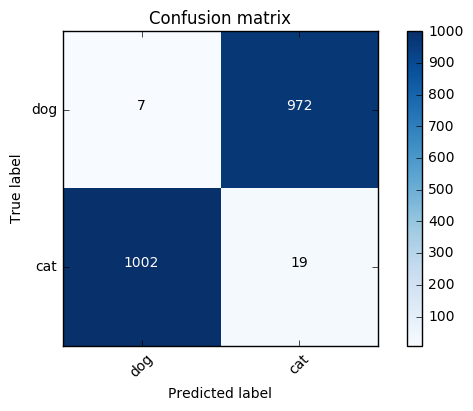

In [53]:
cm = confusion_matrix(val_classes, our_lable_binary)
plot_confusion_matrix(cm, {'cat':0, 'dog':1})